# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.



## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [1]:
import numpy as np

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate, Lambda
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess


In [4]:
import ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [5]:
from task import Task

In [6]:
init_pose = np.array([0.,25.,150.,0.,0.,0.])
init_velocities = np.array([0.,0.,0.])
init_angle = np.array([0.,0.,0.])
runtime = 10.
target_pos = np.array([0.,0.,150.])
action_low = 0
action_high = 900
action_range = action_high - action_low

In [7]:
# Get the environment and extract the number of actions.
task = Task(init_pose, init_velocities, init_angle, runtime, target_pos)
np.random.seed(123)

nb_actions = task.action_size

In [8]:
# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + task.reset().shape ))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('sigmoid'))
actor.add(Lambda(lambda x: (x * 450) + 0))
print(actor.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                112       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
__________

In [9]:
action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,)+task.reset().shape , name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('sigmoid')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  (None, 1, 6)         0                                            
__________________________________________________________________________________________________
action_input (InputLayer)       (None, 4)            0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 6)            0           observation_input[0][0]          
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 10)           0           action_input[0][0]               
                                                                 flatten_2[0][0]                  
__________

In [10]:
# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

In [11]:
agent.load_weights('ddpg_{}_weights.h5f'.format("quad_sim"))

In [16]:
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.

history_1 = agent.fit(task, nb_steps=30000, action_repetition=3, verbose=1, visualize=False)

Training for 30000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 201s 20ms/step - reward: 1.8120
83 episodes - episode_reward: 215.781 [129.121, 404.495] - loss: 17.266 - mean_absolute_error: 3.031 - mean_q: 86.160

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 201s 20ms/step - reward: 1.7970
82 episodes - episode_reward: 220.913 [117.630, 389.755] - loss: 18.333 - mean_absolute_error: 3.058 - mean_q: 86.342

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 201s 20ms/step - reward: 2.0096
done, took 602.192 seconds


In [17]:
# After training is done, we save the final weights.
agent.save_weights('ddpg_{}_weights.h5f'.format("quad_sim"), overwrite=True)

Testing for 5 episodes ...
Episode 1: reward: 337.973, steps: 167
Episode 2: reward: 337.973, steps: 167
Episode 3: reward: 337.973, steps: 167
Episode 4: reward: 337.973, steps: 167
Episode 5: reward: 337.973, steps: 167


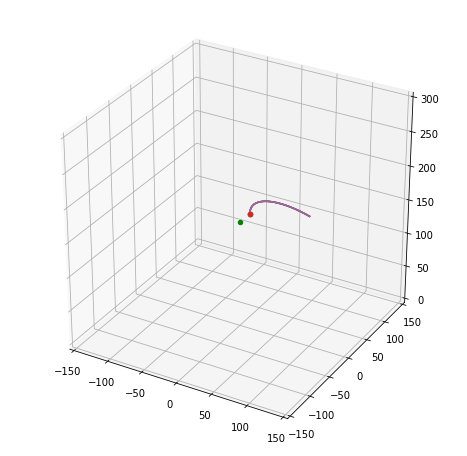

In [12]:
# Finally, evaluate our algorithm for 5 episodes.
agent.test(task, nb_episodes=5, action_repetition=3, visualize=True)

In [14]:
print(history.history.keys())

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


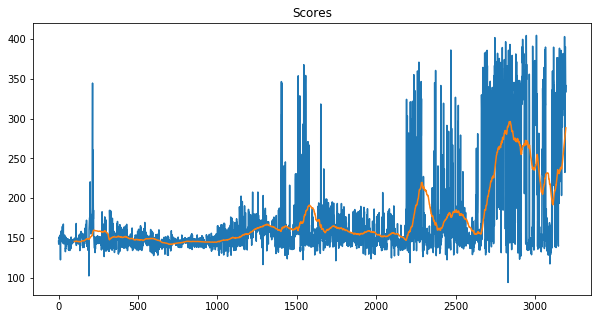

In [20]:
#mport matplotlib.pyplot as plt
import pandas as pd
#matplotlib inline

def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.figure(figsize=(10,5))
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(history.history['episode_reward'] + history_1.history['episode_reward'])

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:
**The task was to move from the initial position to a new target position and then stay there for the remainder of the runtime. The reward function is the normalized 3D distance formula set between 0 and 1, 1 being right on target. In previous iterations I had put bonuses near the target and also put punishments at the boundaries of the simulation but these had little positive affect and mostly just hindered performance.**

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:
**The agent is a DDPG type agent. It uses an actor and critic pair to update the policy. The actor network is trying to perform the task as best it can while the critic network tries to instruct it how to do it better next time. These take the place of the State Value (V) and State-Action Value (Q). The infrastructure was taken and adapted from the DDPG example agent in Keras-RL. I never got the provided example DDPG network to properly learn and would often just do random actions without getting better results. **

**Hyperparameters were Gamma=0.99, Theta=0.15 Mu=0 Sigma=0.3 and a Learning Rate of 0.001**

**The layer summary for the actor and critic network can be seen above. Actor network was 1 Flattened input layer (state), 4 Dense layers, and a Lambda layer. The first three Dense layers were 16 nodes each with relu activation and the final one was 4 nodes corresponding to the 4 actions to be taken with sigmoid activation. The Lambda layer just scaled the sigmoid output into the range of possible actions (0,450) which were halved fromt he orginal to give more stability. The critic network is 4 Dense layers after the concatenation of the inputs (state,action). The first three were 32 nodes with relu and the fourth is 1 node with sigmoid activation. The output correspondes with the estimated Q value. **

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:
**It is a hard task to learn. Even with all the time and effort and iteration I put into the project I still don't feel all that great about the performance of the quadcopter. I could be way better given more dedication and a lot more time. The task had it's aha moment and suddenly jumped from a poor performance to a decent performance. I've let it run even longer before and it would actually wind up exploring even more and getting a worse result. In testing the reward was 337 which is pretty decent given that max reward for a run would be 500. Max reward being the quad started at the target and remained at the target for all 500 timesteps receiving a reward of 1 each timestep.**

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
**This was by far the hardest project of the course. I spent 2 weeks tinkering and puzzling over this project were most others projects took a few hours to a day at most. I spent several hours multiple days trying to learn to plot in 3D so I could visualize what the quadcopter was actually doing as seen above. I thought it was funny how many times the quadcopter would just fall out of the sky before it learned to fly at all. I also spent a long time trying many iteration on task and in particular reward structure. As well, I spent days trying to get the provided code to work out with a proper result and never could get it there which is when I switched to the Keras-RL infrastructure. Overall, though I learned a ton about RL and really about not giving up. I wanted to turn this project in so many times before this but was never happy enough with the results as they would always be a flat line. I finally got a result that showed the agent learning and improving over time and that was good enough for me at this point. Someday when I have more experince I would love to revisit this project and see if I fair any better at the task but for now this is as good as I have.**